In [10]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from Environment import SpringMass
from Subrountines import ModelEst,RobustCE,ApproxDAP,max_norm,OMEGA,M_mid
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def safe_learning():
    x_0 = np.array([0,0]).reshape(-1,1)
    env = SpringMass(x_0 = x_0)

    x_hist = []
    u_hist = []
    time_steps = 500

    # main loop
    for _ in range(time_steps):
        x_hist.append(env.state())
        u = np.random.rand() * 0.01
        env.step(u)
        u_hist.append(u)
    x_hist.append(env.state())

    x_hist = np.array(x_hist).reshape(len(x_hist),-1)
    u_hist = np.array(u_hist).reshape(len(u_hist),-1)
    if len(x_hist.shape)>1:
        x_dim  = x_hist.shape[-1]
    else:
        x_dim = 1

    if len(u_hist.shape)>1:
        u_dim = u_hist.shape[-1]
    else:
        u_dim = 1

  
    
    # The constraint matrices
    O = np.zeros((x_dim,x_dim))
    I = np.eye(x_dim)  

    
    D_x = np.vstack([I,-I]) # Constraints
    d_x = np.array([4,2,4,2]).reshape(-1,1)


    
    O = np.zeros((u_dim,u_dim))
    I = np.eye(u_dim)  
    
    D_u = np.vstack([I,-I])
    d_u = np.array([5,5]).reshape(-1,1)

    x_max = max_norm(D_x,d_x)

    u_max = max_norm(D_u,d_u)

    eta_bar = 1

    H = 40 # Lookback Horizon

    D_M = 0.5 # Delta between M_t and M_t+1

    n_episodes = 40

    w_max = env.w_max

    A_0,B_0,r_0 = ModelEst(x_hist,u_hist,eta_bar)

    A_hat = A_0
    B_hat = B_0
    r = r_0


    M_0 = RobustCE(A_0,B_0,r_0,H,eta_bar,D_M,D_x,d_x,D_u,d_u,x_max,u_max,x_hist,u_hist,env.w_max)

    M = np.array(M_0)
    M_prev = np.array(M_0)

    A_prev = A_0
    B_prev = B_0
    r_prev = r_0
    x_prev = x_hist
    u_prev = u_hist

    # print(len(x_hist),len(u_hist))

    for e in range(n_episodes):

        # Phase 1: Control with explorative noise, eta_bar!=0.

        M_dest = RobustCE(A_hat,B_hat,r,H,eta_bar,D_M,D_x,d_x,D_u,d_u,x_max,u_max,x_hist,u_hist,env.w_max)

        M_dest = np.array(M_dest)

        mid = M_mid(A_hat,B_hat,r,H,eta_bar,D_M,D_x,d_x,D_u,d_u,x_max,u_max,x_hist,u_hist,w_max,A_prev,B_prev,r_prev,eta_bar,x_prev,u_prev,M_prev,M_dest)
#         print(mid,M_prev)
        W_1 = int(np.max([H,np.ceil(np.linalg.norm(mid-M_prev)/D_M)]))
        W_2 = int(np.max([H,np.ceil(np.linalg.norm(M_dest-mid)/D_M)]))

        if r<r_prev:
            A_min = A_prev
            B_min = B_prev
        else:
            A_min = A_hat
            B_min = B_hat

        # Safe Transition
        # Going from M to mid
        for _ in range(W_1):

            M = M + 1/W_1 * (mid-M_prev)

            # Calculate u
            u = ApproxDAP(M,A_min,B_min,eta_bar,x_hist,u_hist).flatten()

            # Step the environment, collect data
            if len(u.shape)<=1:
                env.step(u[0])
            else:
                env.step(u)

            x_hist = np.vstack([x_hist,env.state().T])
            u_hist = np.vstack([u_hist, u])

        # Safe Transition
        # Going from mid to M_prev
        for _ in range(W_2):

            M = M + 1/W_2 * (M_dest-mid)

            # Calculate u
            u = ApproxDAP(M,A_hat,B_hat,eta_bar,x_hist,u_hist).flatten()

            # Step the environment, collect data
            if len(u.shape)<=1:
                env.step(u[0])
            else:
                env.step(u)

            x_hist = np.vstack([x_hist,env.state().T])
            u_hist = np.vstack([u_hist, u])

        A_prev = A_hat
        B_prev = B_hat
        r_prev = r
        eta_bar_prev = eta_bar
        x_prev = x_hist
        u_prev = u_hist

        # Model Update
        A_hat,B_hat,r = ModelEst(x_hist,u_hist,eta_bar)


        # Phase 2: Pure exploitation, eta_bar=0.
        M_prev = RobustCE(A_hat,B_hat,r,H,  0  ,D_M,D_x,d_x,D_u,d_u,x_max,u_max,x_hist,u_hist,env.w_max)

        M_prev = np.array(M_prev)

        mid = M_mid(A_prev,B_prev,r_prev,H,eta_bar,D_M,D_x,d_x,D_u,d_u,x_max,u_max,x_prev,u_prev,w_max,A_hat,B_hat,r,eta_bar,x_hist,u_hist,M_dest,M_prev)
#         print(mid,M_prev)
        W_1 = int(np.max([H,np.ceil(np.linalg.norm(mid-M_dest)/D_M)]))
        W_2 = int(np.max([H,np.ceil(np.linalg.norm(M_prev-mid)/D_M)]))

        if r<r_prev:
            A_min = A_prev
            B_min = B_prev
        else:
            A_min = A_hat
            B_min = B_hat

        # Safe Transition
        # Going from M to mid
        for _ in range(W_1):

            M = M + 1/W_1 * (mid-M_dest)

            # Calculate u
            u = ApproxDAP(M,A_min,B_min, 0 ,x_hist,u_hist).flatten()

            # Step the environment, collect data
            if len(u.shape)<=1:
                env.step(u[0])
            else:
                env.step(u)

            x_hist = np.vstack([x_hist,env.state().T])
            u_hist = np.vstack([u_hist, u])

        # Safe Transition
        # Going from mid to M_prev
        for _ in range(W_2):

            M = M + 1/W_2 * (M_prev-mid)

            # Calculate u
            u = ApproxDAP(M,A_hat,B_hat, 0 ,x_hist,u_hist).flatten()

            # Step the environment, collect data
            if len(u.shape)<=1:
                env.step(u[0])
            else:
                env.step(u)

            x_hist = np.vstack([x_hist,env.state().T])
            u_hist = np.vstack([u_hist, u])

    return x_hist,u_hist
    
def plain():
    x_0 = np.array([0,0]).reshape(-1,1)
    env = SpringMass(x_0 = x_0)

    x_hist = []
    u_hist = []
    time_steps = 1700



    # main loop
    for _ in range(time_steps):
        x_hist.append(env.state())
        u = np.random.rand() * 0.0
        env.step(u)
        u_hist.append(u)
    x_hist.append(env.state())


    x_hist = np.array(x_hist).reshape(len(x_hist),-1)
    u_hist = np.array(u_hist).reshape(len(u_hist),-1)
    return x_hist,u_hist

In [14]:
x_hist,u_hist = safe_learning()

plain_x,plain_u = plain()

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

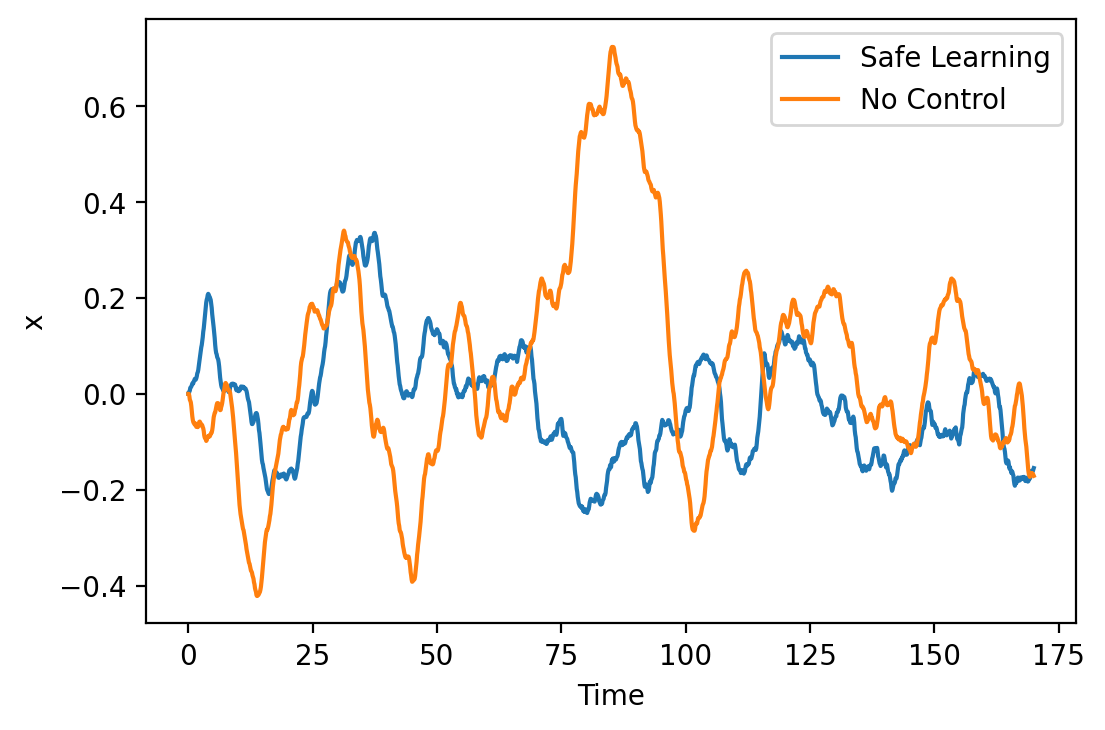

In [12]:
plt.figure(dpi=200)
# plt.plot(np.arange(len(plain_x))*0.1,np.abs(x_hist[:len(plain_x),0]),label='Safe Learning')
# plt.plot(np.arange(len(plain_x))*0.1,np.abs(plain_x[:len(plain_x),0]),label='No Control')
plt.plot(np.arange(len(plain_x))*0.1,x_hist[:len(plain_x),0],label='Safe Learning')
plt.plot(np.arange(len(plain_x))*0.1,plain_x[:len(plain_x),0],label='No Control')

plt.legend()
plt.xlabel('Time')
plt.ylabel('x')
plt.show()

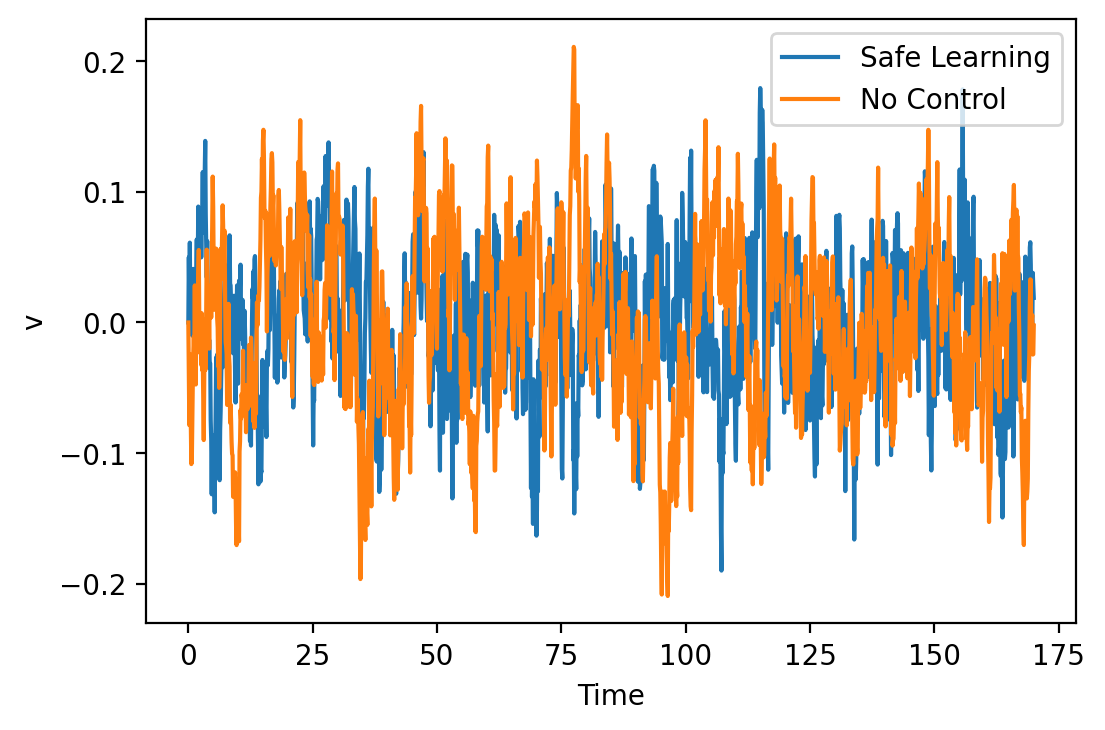

In [13]:
plt.figure(dpi=200)
# plt.plot(np.arange(len(plain_x))*0.1,np.abs(x_hist[:len(plain_x),0]),label='Safe Learning')
# plt.plot(np.arange(len(plain_x))*0.1,np.abs(plain_x[:len(plain_x),0]),label='No Control')
plt.plot(np.arange(len(plain_x))*0.1,x_hist[:len(plain_x),1],label='Safe Learning')
plt.plot(np.arange(len(plain_x))*0.1,plain_x[:len(plain_x),1],label='No Control')

plt.legend()
plt.xlabel('Time')
plt.ylabel('v')
plt.show()